In [160]:
import torch
import math
import matplotlib.pyplot as plt


In [161]:
# prompt: I want a code to represent this network of Value nodes that I have created

# !pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular node for it
    dot.node(name = uid, label = "{ %s|data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this op node to the value node
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# draw_dot(e)

In [162]:
print('cuda' if torch.cuda.is_available else 'cpu')

cuda


In [165]:
class Value:
  def __init__(self,data, _children = (), _op="", label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, _children = (self,other), _op="+")
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, _children = (self,other), _op="*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children = (self,), _op="tanh")
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out




  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for neuron in reversed(topo):
      neuron._backward()




In [166]:
x1 = Value(5, label = 'x1')
x2 = Value(6, label = 'x2')
w1 = Value(-3, label = 'w1')
w2 = Value(2, label = 'w2')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2.tanh(); n.label = 'tanh(x1*w1 + x2*w2)'
# e = (2*n).exp(); e.label = 'e(2*n)'

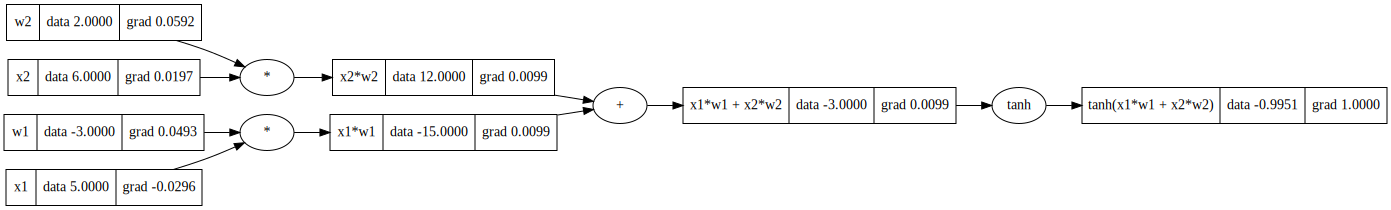

In [170]:
draw_dot(n)

In [169]:
n.backward()